In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1. Import libraries and load data

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df = pd.read_csv(os.path.join("/content/drive/MyDrive/ColabNotebooks/data", "train.csv"))

In [ ]:
df

id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
0           0             0        0       0       0              0  
1           0             0        0       0       0              0  
2           0             0        0       0       0              0  
3           0             0        0       0       0              0  
4           0             0        0       0       0              0  
...       ...           ...      ...     ...     ...            ...  
159566      0             0        0       0       0              0  
159567      0             0        0       0       0              0  
159568      0             0        0       0       0              0  
159569      0             0        0       0       0              0  
159570      0             0        0       0       0              0  

[159571 rows x 8 columns]

# 2. Preprocessing

## 2.1. Data overview

In [ ]:
df[df.columns[2:]]

toxic  severe_toxic  obscene  threat  insult  identity_hate
0           0             0        0       0       0              0
1           0             0        0       0       0              0
2           0             0        0       0       0              0
3           0             0        0       0       0              0
4           0             0        0       0       0              0
...       ...           ...      ...     ...     ...            ...
159566      0             0        0       0       0              0
159567      0             0        0       0       0              0
159568      0             0        0       0       0              0
159569      0             0        0       0       0              0
159570      0             0        0       0       0              0

[159571 rows x 6 columns]

In [ ]:
df.loc[df.iloc[:, 2]==1].head()

id                                       comment_text  \
6   0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK   
12  0005c987bdfc9d4b  Hey... what is it..\n@ | talk .\nWhat is it......   
16  0007e25b2121310b  Bye! \n\nDon't look, come or think of comming ...   
42  001810bf8c45bf5f  You are gay or antisemmitian? \n\nArchangel WH...   
43  00190820581d90ce           FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!   

    toxic  severe_toxic  obscene  threat  insult  identity_hate  
6       1             1        1       0       1              0  
12      1             0        0       0       0              0  
16      1             0        0       0       0              0  
42      1             0        1       0       1              1  
43      1             0        1       0       1              0

In [ ]:
df.iloc[12].comment_text

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

## 2.2. Data preprocessing

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
X = df.comment_text
y = df.iloc[:,2:].values

In [ ]:
# number of words in vocab
MAX_VOCAB = 200000

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_VOCAB, 
                               output_sequence_length=1800, 
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
vectorizer('Hello world, welcome to this project')[:6]

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([288, 263, 191,   3,  14, 463])>

In [ ]:
processed_text = vectorizer(X.values)

In [ ]:
processed_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [ ]:
# MCSHBAP - map, cache, shuffle, batch, prefetch
# from_tensor_slices OR list_file
data = tf.data.Dataset.from_tensor_slices((processed_text, y))
data = data.cache()
data = data.shuffle(160000)
data = data.batch(16)
data = data.prefetch(8) # prevent bottleneck

In [ ]:
batch_X, batch_y = data.as_numpy_iterator().next()

In [ ]:
batch_X.shape

(16, 1800)

In [ ]:
train = data.take(int(len(data) * .7))
val = data.skip(int(len(data) * .7)).take(int(len(data)*.2))
test = data.take(int(len(data) * .9)).take(int(len(data)*.1))

In [ ]:
len(train)

6981

In [ ]:
train.as_numpy_iterator().next()

(array([[ 5495,    51,    29, ...,     0,     0,     0],
        [   33,     7,    69, ...,     0,     0,     0],
        [   24,  1805,  2256, ...,     0,     0,     0],
        ...,
        [   46,  1377,    31, ...,     0,     0,     0],
        [ 4354, 41514,     8, ...,     0,     0,     0],
        [  215,     8,   477, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

# 3. Buiding model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
model.add(Embedding(MAX_VOCAB + 1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                      

In [ ]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 642s 92ms/step - loss: 0.0645 - val_loss: 0.0441
Epoch 2/10
6981/6981 [==============================] - 639s 91ms/step - loss: 0.0458 - val_loss: 0.0398
Epoch 3/10
6981/6981 [==============================] - 660s 94ms/step - loss: 0.0412 - val_loss: 0.0366
Epoch 4/10
6981/6981 [==============================] - 639s 91ms/step - loss: 0.0371 - val_loss: 0.0335
Epoch 5/10
6981/6981 [==============================] - 648s 93ms/step - loss: 0.0335 - val_loss: 0.0297
Epoch 6/10
6981/6981 [==============================] - 634s 91ms/step - loss: 0.0307 - val_loss: 0.0261
Epoch 7/10
6981/6981 [==============================] - 634s 91ms/step - loss: 0.0278 - val_loss: 0.0254
Epoch 8/10
6981/6981 [==============================] - 634s 91ms/step - loss: 0.0252 - val_loss: 0.0231
Epoch 9/10
6981/6981 [==============================] - 623s 89ms/step - loss: 0.0234 - val_loss: 0.0193
Epoch 10/10
6981/6981 [==============================] 

In [ ]:
import matplotlib.pyplot as plt

<Figure size 576x360 with 0 Axes>

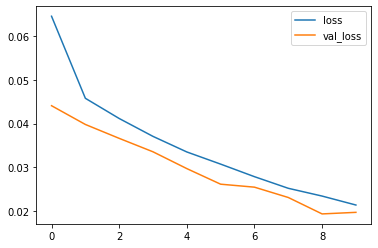

In [ ]:
plt.figure(figsize=(8, 5))
pd.DataFrame(history.history).plot()
plt.show()

# 4. Make predictions

In [ ]:
text = vectorizer("you shit")
text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([  7, 318,   0, ...,   0,   0,   0])>

In [ ]:
np.expand_dims(text, 0)

array([[  7, 318,   0, ...,   0,   0,   0]])

In [ ]:
res = model.predict(np.expand_dims(text, 0))
res

array([[0.9876286 , 0.15251058, 0.9701179 , 0.0023339 , 0.33286613,
        0.00344882]], dtype=float32)

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
pred = (model.predict(batch_X) > 0.5).astype(int)
pred

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
pred = pred.flatten()
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

# 5. Evaluate model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    pred = model.predict(X_true)

    y_true = y_true.flatten()
    pred = pred.flatten()

    pre.update_state(y_true, pred)
    re.update_state(y_true, pred)
    acc.update_state(y_true, pred)

In [ ]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 0.9102380275726318, Recall: 0.9139072895050049, Accuracy: 0.49949848651885986


In [ ]:
model.save('toxic-detect.h5')

# 5. Test and Gradio

In [ ]:
!pip install gradio jinja2

In [ ]:
import gradio as gr

In [ ]:
model = tf.keras.models.load_model('toxic-detect.h5')

In [ ]:
def evaluate_comment(Comment):
    processed_Comment = vectorizer([Comment])
    res = model.predict(processed_Comment)

    text = ''
    for i, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, 'Violate' if res[0][i] > 0.5 else 'None')
    
    return text

In [ ]:
interface = gr.Interface(fn = evaluate_comment, 
                         inputs = gr.inputs.Textbox(lines = 4, placeholder='Comment to evaluate'), 
                         outputs = 'text')

In [ ]:
interface.launch(share=True)